In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

## Import data

In [227]:
df = pd.read_csv('abalone.data', header = None)

In [228]:
df.columns = [
 "Sex", "Length", "Diameter", "Height",
 "WholeWeight", "ShuckedWeight",
 "VisceraWeight", "ShellWeight", "Rings"
]

## Initial understanding

In [88]:
df.shape

(4177, 9)

In [89]:
df.isnull().sum()

,0
Sex,0
Length,0
Diameter,0
Height,0
WholeWeight,0
ShuckedWeight,0
VisceraWeight,0
ShellWeight,0
Rings,0


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            4177 non-null   object 
 1   Length         4177 non-null   float64
 2   Diameter       4177 non-null   float64
 3   Height         4177 non-null   float64
 4   WholeWeight    4177 non-null   float64
 5   ShuckedWeight  4177 non-null   float64
 6   VisceraWeight  4177 non-null   float64
 7   ShellWeight    4177 non-null   float64
 8   Rings          4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [91]:
df.describe()

,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


## Feature Conversion to numeric

In [229]:
df = pd.get_dummies(df, columns=["Sex"])
df.head()

,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,False,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,False,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,True,False,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,False,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,False,True,False


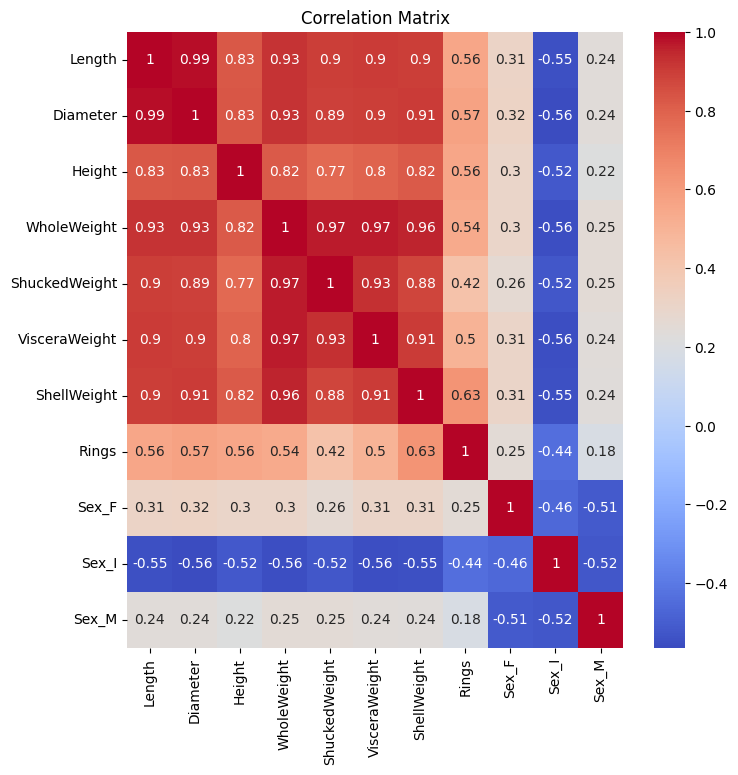

In [93]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Handling outliers

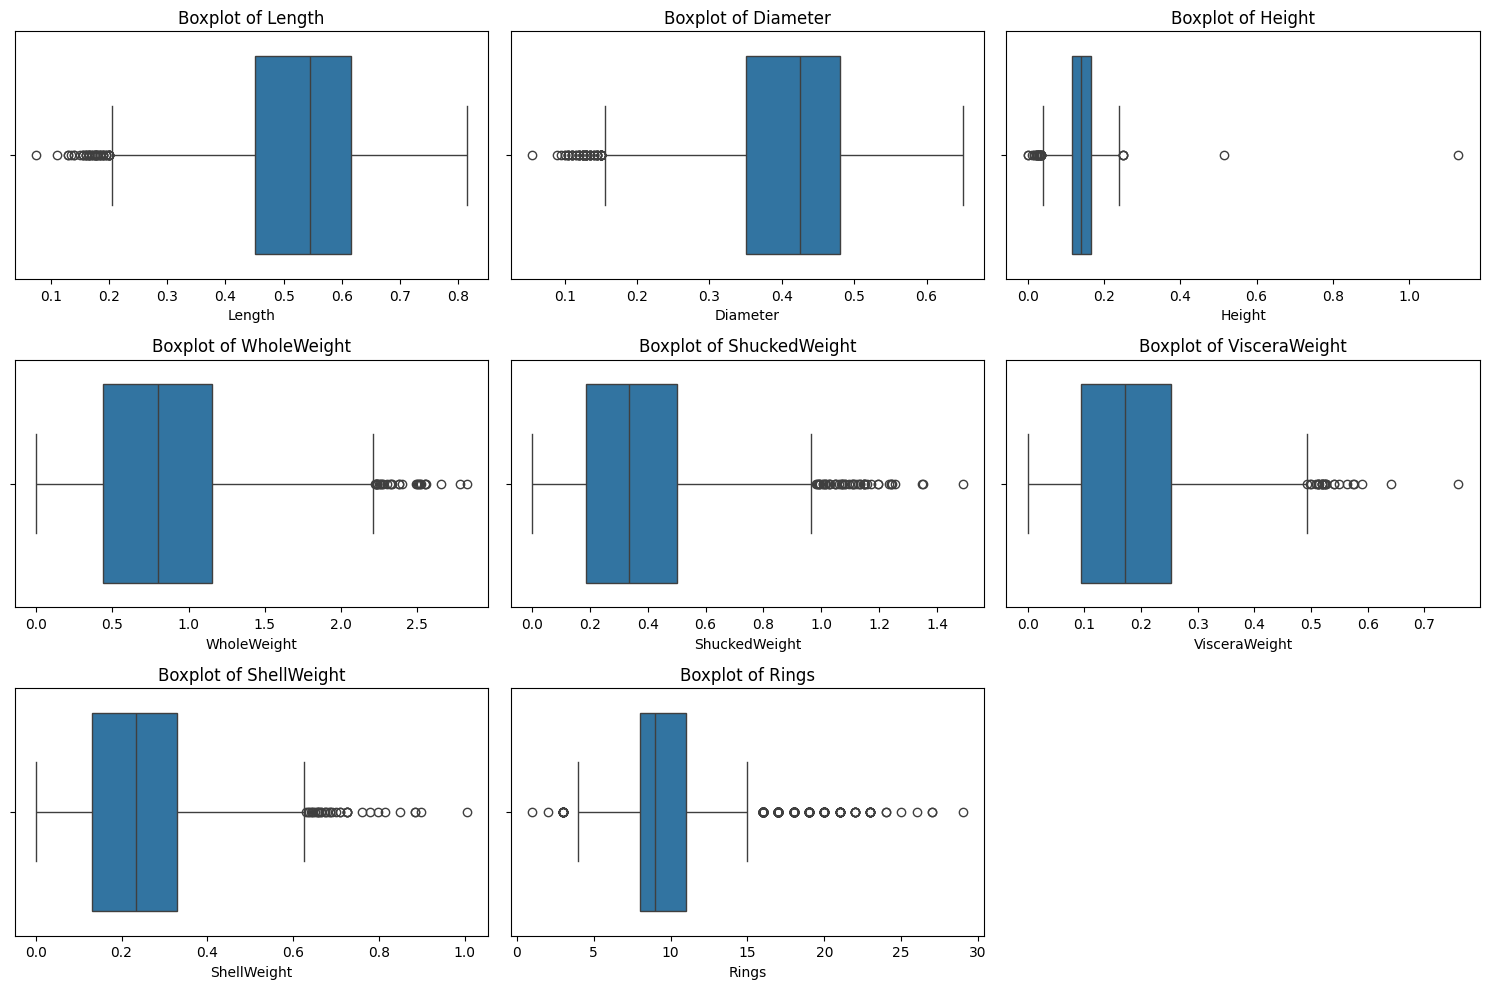

In [94]:
numerical_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [230]:
numerical_cols = numerical_cols.difference(["Rings"])
error_rows = df[(df[numerical_cols] == 0).any(axis=1)]
display(error_rows)

,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings,Sex_F,Sex_I,Sex_M
1257,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8,False,True,False
3996,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6,False,True,False


In [231]:
df = df.drop(error_rows.index)

In [97]:
df['outlier'] = None

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    outliers = df[(df[col] > upper) | (df[col] < lower)][col]
    df.loc[outliers.index, 'outlier'] = col

In [98]:
df[df['outlier'] != None]
df['outlier'].value_counts()

,count
outlier,
Length,49
WholeWeight,30
ShellWeight,24
ShuckedWeight,21
VisceraWeight,12
Diameter,11
Height,4


#### These outliers are important data for extreme cases of each feature hence no handling needed.

In [107]:
df.drop(['outlier'], axis=1, inplace=True)

# Feature scaling and handling skewness

In [232]:
for col in numerical_cols:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

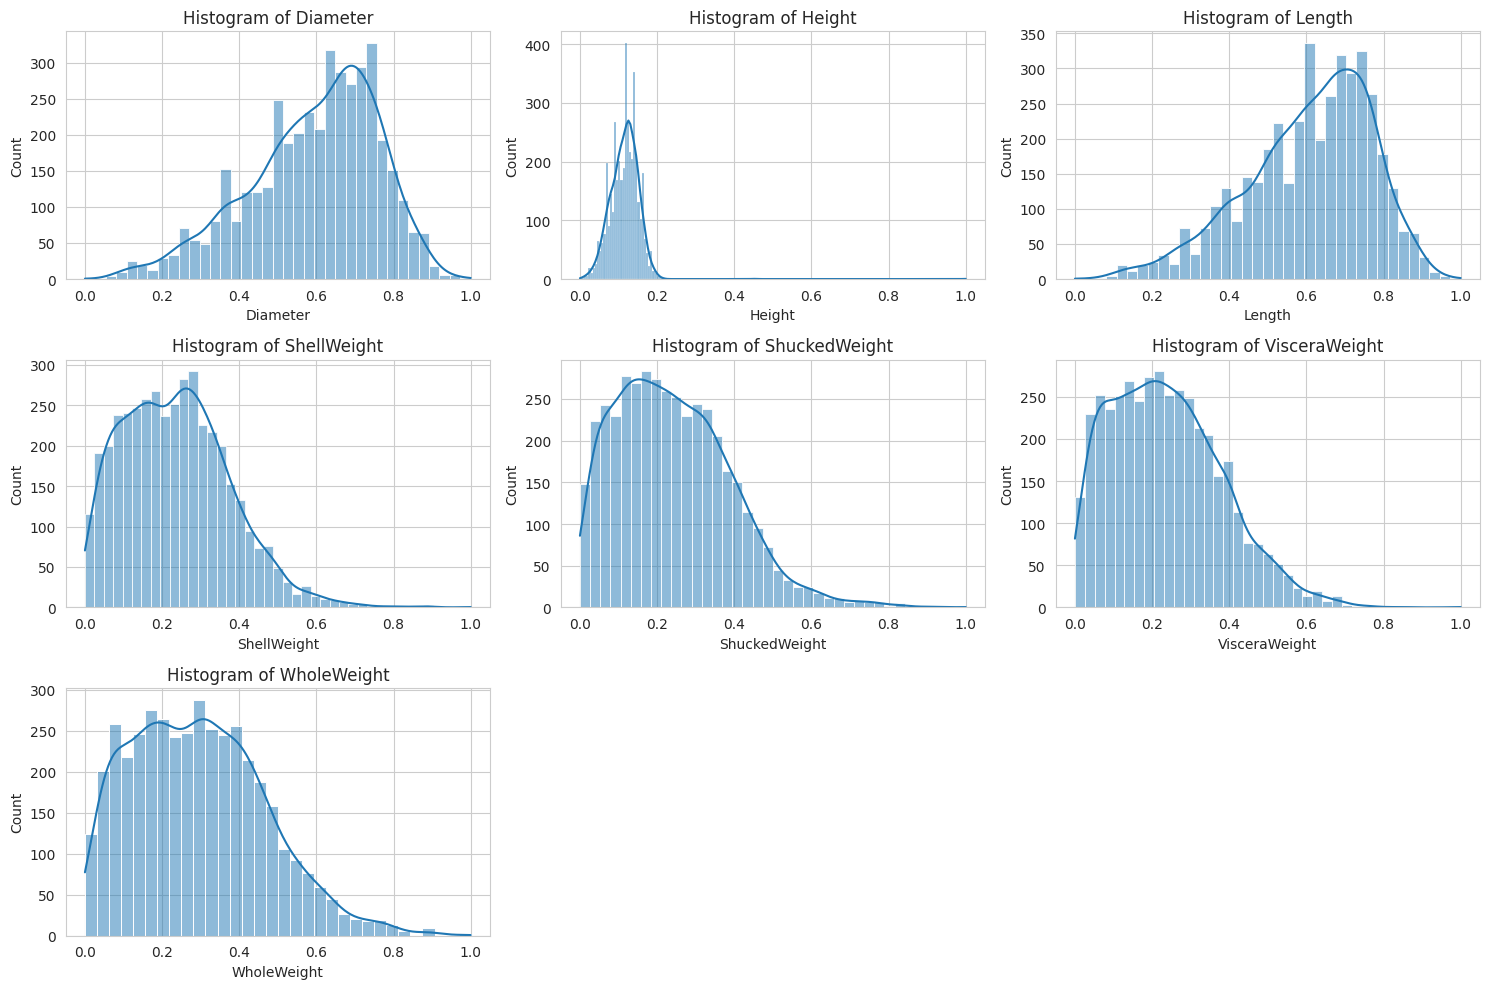

In [233]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

In [234]:
skew = pd.DataFrame({
    'Feature': numerical_cols,
    'Skewness': [df[col].skew() for col in numerical_cols]
})
skew

,Feature,Skewness
0,Diameter,-0.610182
1,Height,3.166364
2,Length,-0.640993
3,ShellWeight,0.621081
4,ShuckedWeight,0.718735
5,VisceraWeight,0.591455
6,WholeWeight,0.530549


In [235]:
for skew in skew[skew['Skewness'] > 0.5]['Feature']:
    df[skew] = df[skew].apply(np.log1p)

In [236]:
skew = pd.DataFrame({
    'Feature': numerical_cols,
    'Skewness': [df[col].skew() for col in numerical_cols]
})
skew

,Feature,Skewness
0,Diameter,-0.610182
1,Height,1.228093
2,Length,-0.640993
3,ShellWeight,0.315839
4,ShuckedWeight,0.402193
5,VisceraWeight,0.325178
6,WholeWeight,0.229446


# Bi-variate analysis

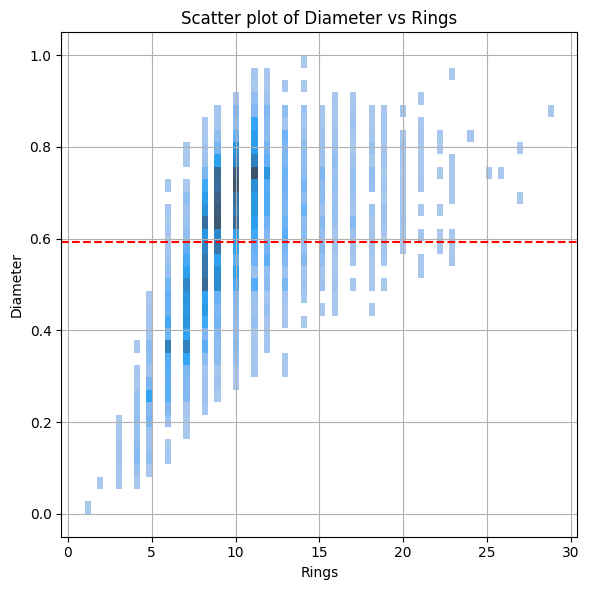

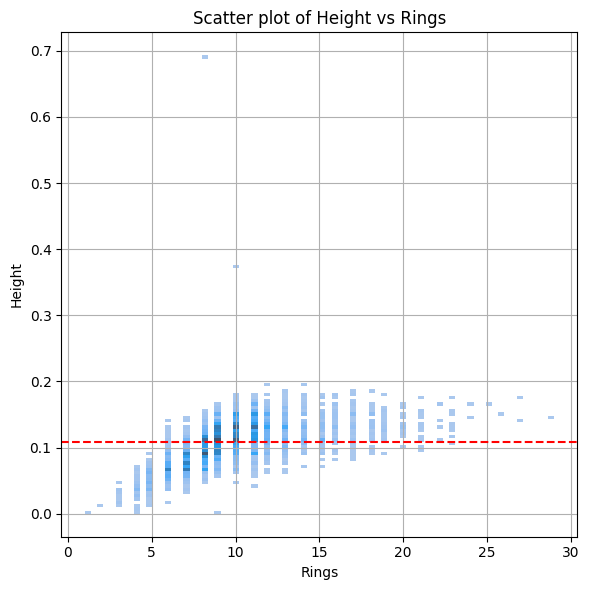

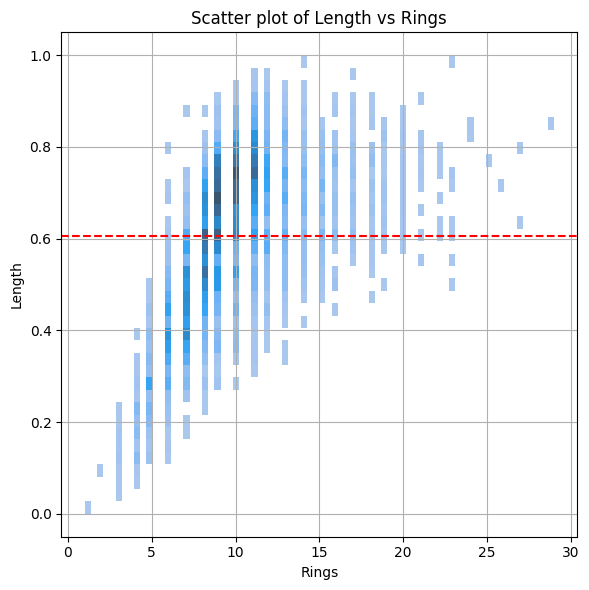

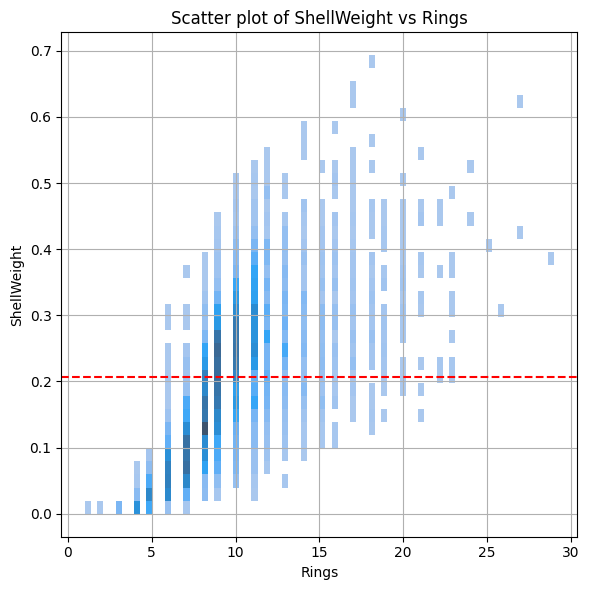

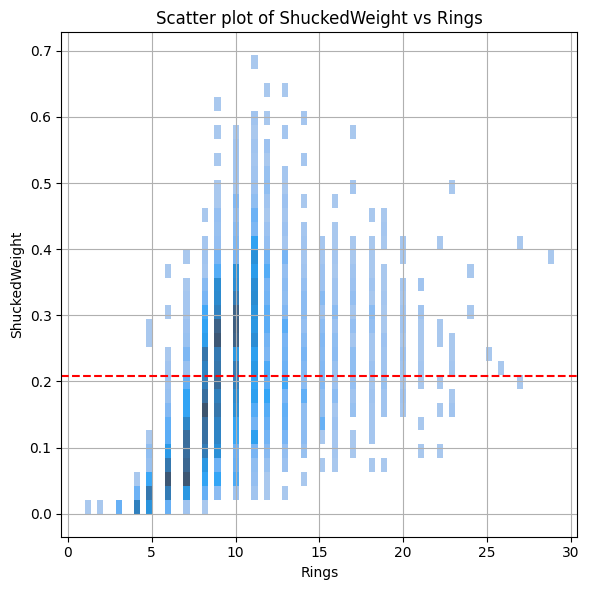

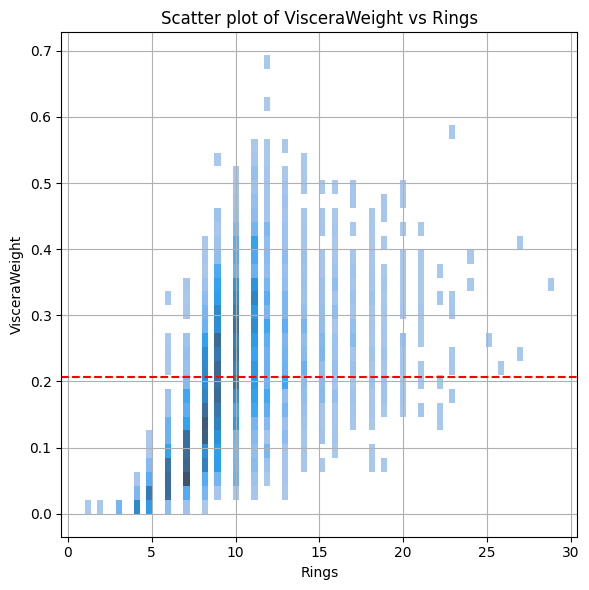

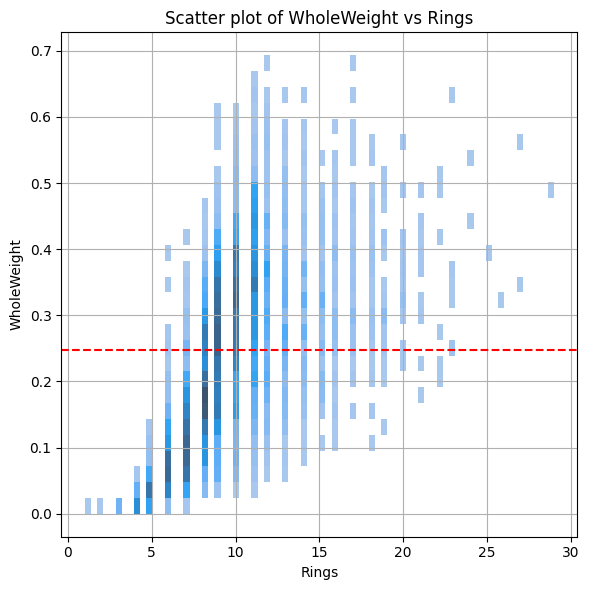

In [122]:
for i, col in enumerate(numerical_cols):
    plt.figure(figsize=(6, 6))
    sns.histplot(data=df, x='Rings', y=col, kde=True)
    plt.title(f'Scatter plot of {col} vs Rings')
    plt.xlabel('Rings')
    plt.ylabel(col)
    plt.axhline(y=df[col].mean(), color='r', linestyle='--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print()

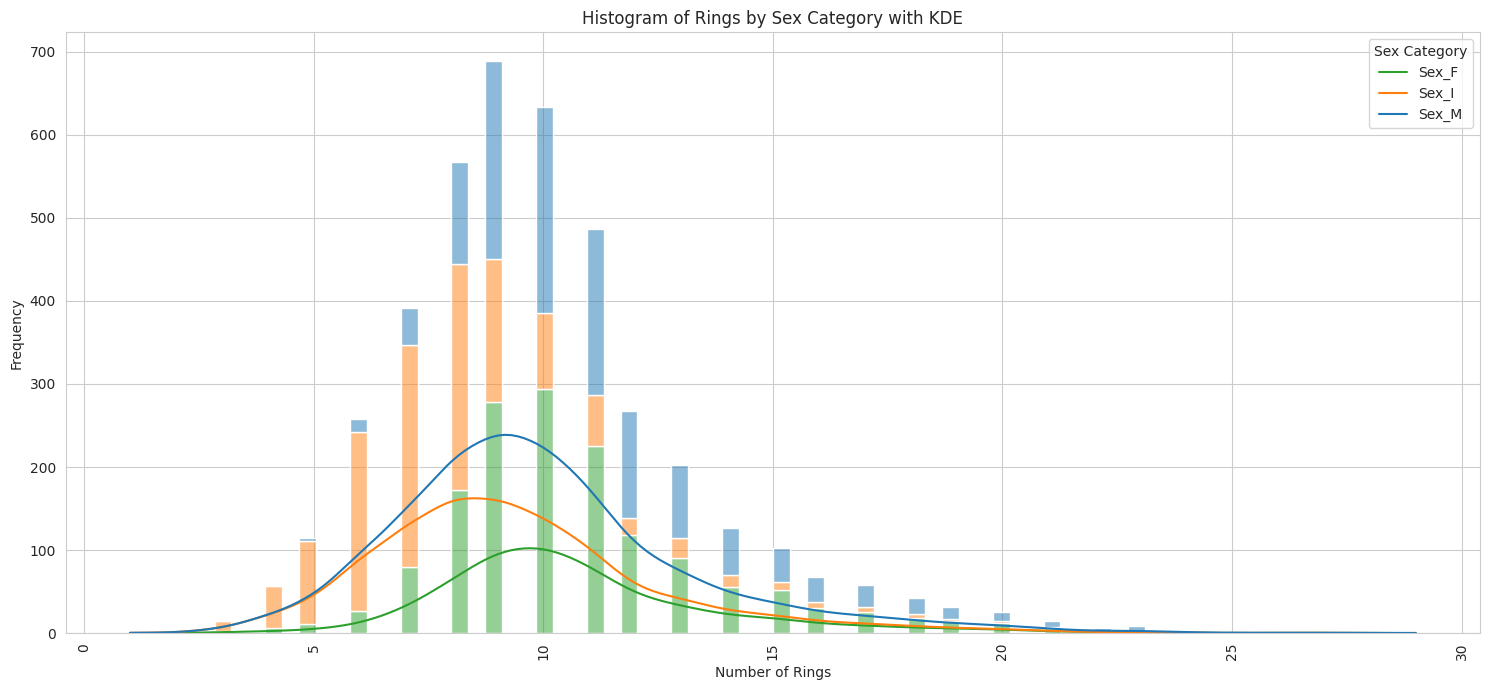

In [152]:
df_long = df.melt(id_vars='Rings', value_vars=['Sex_F', 'Sex_I', 'Sex_M'], var_name='Sex_Category', value_name='Is_Sex')
df_long = df_long[df_long['Is_Sex'] == True]
plt.figure(figsize=(15,7))
sns.histplot(data=df_long, x='Rings', hue='Sex_Category', multiple='stack', kde=True)
plt.title('Histogram of Rings by Sex Category with KDE')
plt.xlabel('Number of Rings')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.legend(title='Sex Category', loc='upper right', labels=['Sex_F', 'Sex_I', 'Sex_M'])
plt.tight_layout()
plt.show()

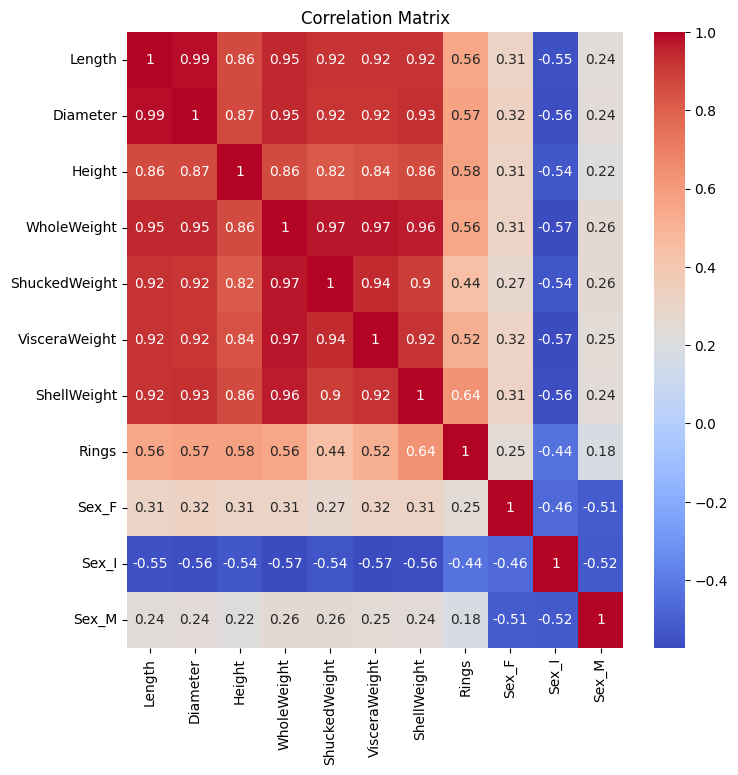

In [108]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Derived Feature

In [237]:
df['length_diameter_height_sqrt'] = np.cbrt(df['Length'] * df['Diameter'] * df['Height'])

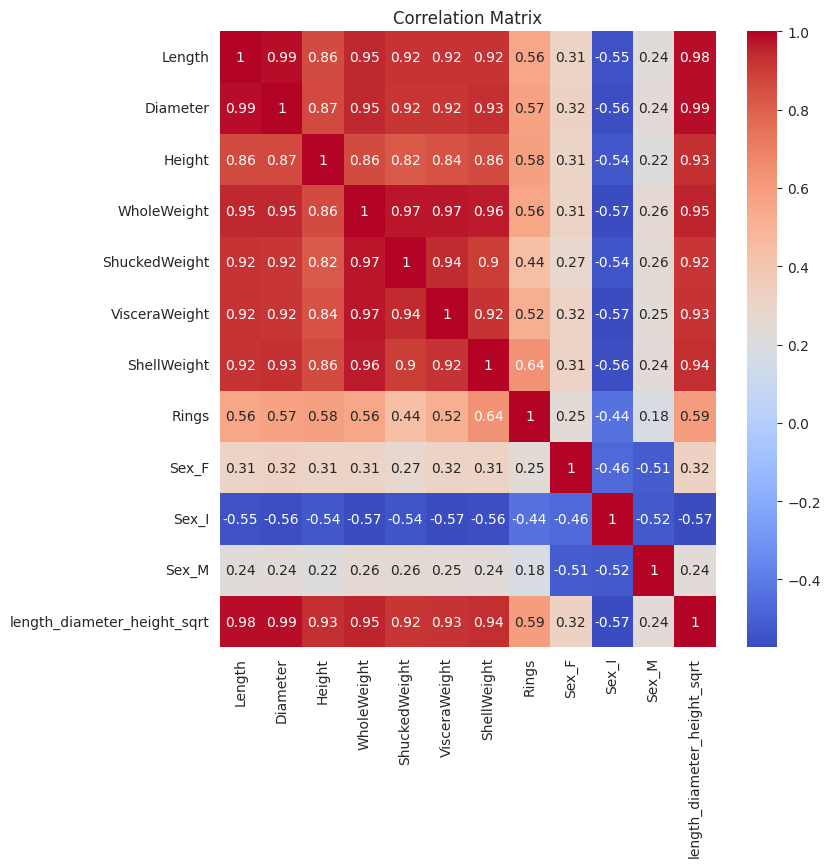

In [198]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Data Split

In [238]:
X = df.drop('Rings', axis=1)
y = df['Rings']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print("X_train rows:", X_train.shape[0])
print("X_test rows:", X_test.shape[0])

X_train rows: 3757
X_test rows: 418


# Models Trial

## Derived Regression


### 2 Feature

In [214]:
X_train1 = X_train[['ShellWeight', 'length_diameter_height_sqrt']]
X_test1 = X_test[['ShellWeight', 'length_diameter_height_sqrt']]

In [208]:
models = {
    'Ridge': (Ridge(), {'alpha': [0.01, 0.1, 1, 10, 100], 'fit_intercept': [True, False], 'positive': [True, False]}),
    'Lasso': (Lasso(), {'alpha': [0.001, 0.01, 0.1, 1, 10], 'fit_intercept':[True, False], 'positive':[True, False], 'max_iter':[1000,5000]}),
    'ElasticNet': (ElasticNet(), {'alpha':[0.001,0.01,0.1,1], 'l1_ratio':[0.1,0.5,0.7,0.9], 'fit_intercept':[True, False], 'max_iter':[1000,5000]})
}

In [216]:
for name, (model, param_grid) in models.items():
    print(f"==== {name} ====")
    grid = GridSearchCV(model, param_grid, cv=5)
    grid.fit(X_train1, y_train)

    y_pred = grid.predict(X_test1)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Best params: {grid.best_params_}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R-squared: {r2:.4f}\n")

==== Ridge ====
Best params: {'alpha': 0.01, 'fit_intercept': True, 'positive': True}
Mean Squared Error: 7.1232
R-squared: 0.4071

==== Lasso ====
Best params: {'alpha': 0.001, 'fit_intercept': True, 'max_iter': 1000, 'positive': True}
Mean Squared Error: 7.1259
R-squared: 0.4069

==== ElasticNet ====
Best params: {'alpha': 0.001, 'fit_intercept': True, 'l1_ratio': 0.9, 'max_iter': 1000}
Mean Squared Error: 7.1447
R-squared: 0.4053



### All features

In [217]:
models = {
    'Ridge': (Ridge(), {'alpha': [0.01, 0.1, 1, 10, 100], 'fit_intercept': [True, False], 'positive': [True, False]}),
    'Lasso': (Lasso(), {'alpha': [0.001, 0.01, 0.1, 1, 10], 'fit_intercept':[True, False], 'positive':[True, False], 'max_iter':[1000,5000]}),
    'ElasticNet': (ElasticNet(), {'alpha':[0.001,0.01,0.1,1], 'l1_ratio':[0.1,0.5,0.7,0.9], 'fit_intercept':[True, False], 'max_iter':[1000,5000]})
}

In [218]:
for name, (model, param_grid) in models.items():
    print(f"==== {name} ====")
    grid = GridSearchCV(model, param_grid, cv=5)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Best params: {grid.best_params_}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R-squared: {r2:.4f}\n")

==== Ridge ====
Best params: {'alpha': 0.01, 'fit_intercept': True, 'positive': False}
Mean Squared Error: 4.8587
R-squared: 0.5956

==== Lasso ====
Best params: {'alpha': 0.001, 'fit_intercept': True, 'max_iter': 1000, 'positive': False}
Mean Squared Error: 5.1032
R-squared: 0.5752

==== ElasticNet ====
Best params: {'alpha': 0.001, 'fit_intercept': False, 'l1_ratio': 0.9, 'max_iter': 5000}
Mean Squared Error: 5.2978
R-squared: 0.5590



## KNN

### Init model

In [249]:
model = KNeighborsRegressor
params = [{
     "n_neighbors": list(range(5, 30))
}]

model = KNeighborsRegressor()
grid = GridSearchCV(model, params, cv=3, n_jobs=-1, verbose=2 )
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best params: {grid.best_params_}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}\n")

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params: {'n_neighbors': 15}
Mean Squared Error: 5.6076
R-squared: 0.5332



### Adding Hyper parameters


In [247]:
params = [
    {   # Case 1: Minkowski with p
        "n_neighbors": list(range(13, 16)),
        "weights": ["uniform", "distance"],
        "leaf_size": list(range(10, 101, 10)),
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        "metric": ["minkowski"],
        "p": [1, 2]
    },
    {   # Case 2: Manhattan / Chebyshev
        "n_neighbors": list(range(13, 16)),
        "weights": ["uniform", "distance"],
        "leaf_size": list(range(10, 101, 10)),
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        "metric": ["manhattan", "chebyshev"]
        # no need for "p"
    },
    {   # Case 3: Cosine (only brute)
        "n_neighbors": list(range(13, 16)),
        "weights": ["uniform", "distance"],
        "algorithm": ["brute"],
        "metric": ["cosine"]
        # no need for "p" or "leaf_size"
    }
]


In [248]:
model = KNeighborsRegressor()
grid = GridSearchCV(model, params, cv=3, n_jobs=-1, verbose=2 )
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best params: {grid.best_params_}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}\n")

Fitting 3 folds for each of 966 candidates, totalling 2898 fits
Best params: {'algorithm': 'brute', 'metric': 'cosine', 'n_neighbors': 15, 'weights': 'distance'}
Mean Squared Error: 5.5359
R-squared: 0.5392



### Confirming Results

In [ ]:
params = [
    {   # Case 3: Cosine (only brute)
        "n_neighbors": list(range(13, 16)),
        "weights": ["uniform", "distance"],
        "algorithm": ["brute"],
        "metric": ["cosine"]
        # no need for "p" or "leaf_size"
    }
]


In [246]:
model = KNeighborsRegressor()
grid = GridSearchCV(model, params, cv=5, n_jobs=-1, verbose=2 )
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best params: {grid.best_params_}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}\n")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'algorithm': 'brute', 'metric': 'cosine', 'n_neighbors': 15, 'weights': 'distance'}
Mean Squared Error: 5.5359
R-squared: 0.5392



## XGBoost

In [253]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Coarse ranges
params_coarse = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

grid_coarse = GridSearchCV(
    xgb, param_grid=params_coarse, cv=3, n_jobs=-1, verbose=2
)
grid_coarse.fit(X_train, y_train)

coarse_best = grid_coarse.best_params_
print("Coarse best params:", coarse_best)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Coarse best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.6}


In [257]:
params_fine = {
    'n_estimators': [max(50, coarse_best['n_estimators']-50), coarse_best['n_estimators'], coarse_best['n_estimators']+50],
    'max_depth': [max(1, coarse_best['max_depth']-1), coarse_best['max_depth'], coarse_best['max_depth']+1],
    'learning_rate': [coarse_best['learning_rate']*0.5, coarse_best['learning_rate'], coarse_best['learning_rate']*1.5],
    'subsample': [max(0.5, coarse_best['subsample']-0.1), coarse_best['subsample'], min(1.0, coarse_best['subsample']+0.1)],
    'colsample_bytree': [max(0.5, coarse_best['colsample_bytree']-0.1), coarse_best['colsample_bytree'], min(1.0, coarse_best['colsample_bytree']+0.1)]
}

grid_fine = GridSearchCV(
    xgb, param_grid=params_fine, cv=3, n_jobs=-1, verbose=2
)
grid_fine.fit(X_train, y_train)

fine_best = grid_fine.best_params_
print("Fine best params:", fine_best)

y_pred = grid_fine.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Fine best params: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 450, 'subsample': 0.6}
Mean Squared Error: 5.2425
R-squared: 0.5636


## Using Models without over data processing and hyper paramater tuning

In [260]:


data = pd.read_csv('abalone.data', header = None)
data.columns = [
 "Sex", "Length", "Diameter", "Height",
 "WholeWeight", "ShuckedWeight",
 "VisceraWeight", "ShellWeight", "Rings"
]

data['Sex'] = data['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X = data.drop('Rings', axis=1)
y = data['Rings']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train2)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")


Mean Squared Error: 4.9503
R-squared: 0.5427


In [265]:
best_r2 = -float('inf')
best_k = None
best_mse = None

for k in range(5, 31):
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train_scaled, y_train2)
    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)

    if r2 > best_r2:
        best_r2 = r2
        best_k = k
        best_mse = mean_squared_error(y_test, y_pred)

print(f"Best k: {best_k}")
print(f"Best MSE: {best_mse:.4f}")
print(f"Best R²: {best_r2:.4f}")

Best k: 15
Best MSE: 5.1209
Best R²: 0.5270


In [267]:
model = XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train2)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

Mean Squared Error: 5.4368
R-squared: 0.4978


##